# DM25 – Lab 2: Text Mining & NLP
## Sentiment Analysis on Sentiment140 Dataset

**Student ID:** a25navbe  
**Dataset:** Sentiment140 (Training Set)

This notebook explores sentiment classification using:
- Bag of Words (BoW)
- TF-IDF
- Word Embeddings (Word2Vec + CNN)

To reduce computational cost, a stratified subset of the dataset is used.


In [1]:
import pandas as pd
import numpy as np
import re

# NLP
import nltk
from nltk.corpus import stopwords

# ML
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC


# DL
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense

nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\navee\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Question 1: Data Exploration and Text Preprocessing
The Sentiment140 dataset contains tweets labeled as:
- 0 → Negative
- 4 → Positive


In [2]:
cols = ['target', 'id', 'date', 'flag', 'user', 'text']

data = pd.read_csv(
    "training.1600000.processed.noemoticon.csv",
    encoding="latin-1",
    names=cols
)

# Keep only necessary columns
data = data[['target', 'text']]

# Convert labels to binary
data['target'] = data['target'].map({0: 0, 4: 1})

data.head()


,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


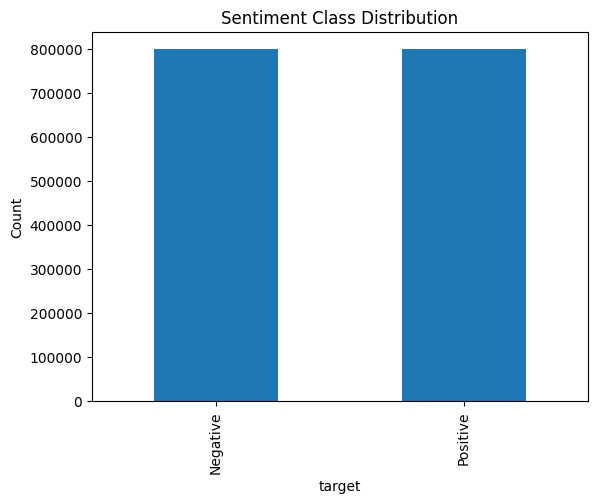

In [3]:
import matplotlib.pyplot as plt

data['target'].value_counts().plot(kind='bar')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.title("Sentiment Class Distribution")
plt.ylabel("Count")
plt.show()


### Question 2: Dataset Reduction
To speed up processing, 30% of the dataset is selected using stratified sampling.


In [4]:
data, _ = train_test_split(
    data,
    train_size=0.3,
    stratify=data['target'],
    random_state=42
)

data['target'].value_counts()


target
0    240000
1    240000
Name: count, dtype: int64

### Question 3: Text Cleaning and Feature Engineering
Steps applied:
- Lowercasing
- URL, mention, hashtag removal
- Stopword removal
- Simple whitespace tokenization


In [5]:
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|@\w+|#\w+", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    tokens = text.split()
    tokens = [w for w in tokens if w not in stop_words]
    return " ".join(tokens)

data['clean_text'] = data['text'].astype(str).apply(clean_text)


### Train-Test Split


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    data['clean_text'],
    data['target'],
    test_size=0.2,
    random_state=42,
    stratify=data['target']
)


### Bag of Words Feature Extraction


In [7]:
bow = CountVectorizer(max_features=5000)
X_train_bow = bow.fit_transform(X_train)
X_test_bow = bow.transform(X_test)


### Question 4: Model Training and Evaluation

KNN Classifier

In [8]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_bow, y_train)

y_pred_knn = knn.predict(X_test_bow)


Decision Tree Classifier

In [9]:
dt = DecisionTreeClassifier(max_depth=20)
dt.fit(X_train_bow, y_train)

y_pred_dt = dt.predict(X_test_bow)


Support Vector Machine (SVM)

In [10]:
svm = LinearSVC()
svm.fit(X_train_bow, y_train)

y_pred_svm = svm.predict(X_test_bow)


### Evaluation Metrics



KNN
Accuracy: 0.6920416666666667
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.62      0.67     48000
           1       0.67      0.77      0.71     48000

    accuracy                           0.69     96000
   macro avg       0.70      0.69      0.69     96000
weighted avg       0.70      0.69      0.69     96000



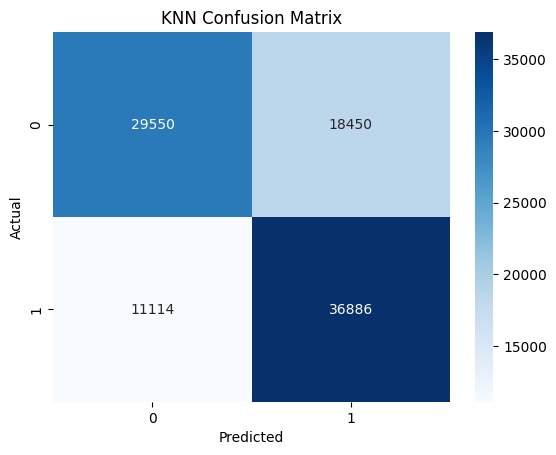


Decision Tree
Accuracy: 0.6260104166666667
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.34      0.47     48000
           1       0.58      0.92      0.71     48000

    accuracy                           0.63     96000
   macro avg       0.69      0.63      0.59     96000
weighted avg       0.69      0.63      0.59     96000



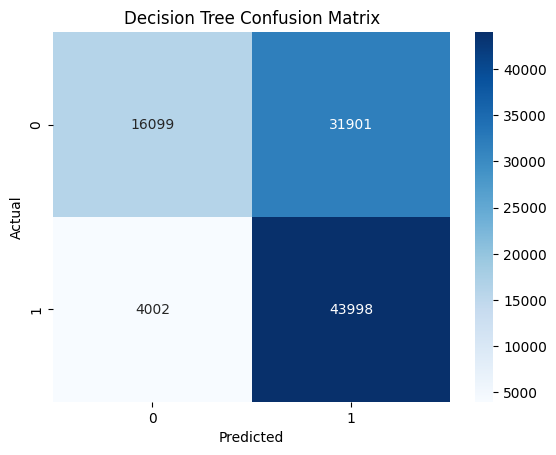


SVM
Accuracy: 0.7684270833333333
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.73      0.76     48000
           1       0.75      0.81      0.78     48000

    accuracy                           0.77     96000
   macro avg       0.77      0.77      0.77     96000
weighted avg       0.77      0.77      0.77     96000



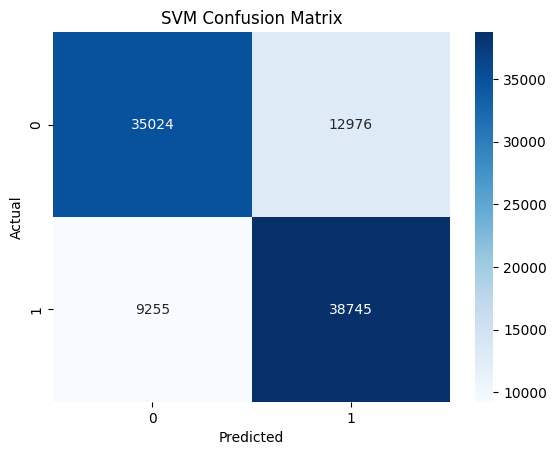

In [11]:
import seaborn as sns

def evaluate_and_plot(name, y_true, y_pred):
    print(f"\n{name}")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Classification Report:\n", classification_report(y_true, y_pred))
    
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

evaluate_and_plot("KNN", y_test, y_pred_knn)
evaluate_and_plot("Decision Tree", y_test, y_pred_dt)
evaluate_and_plot("SVM", y_test, y_pred_svm)


### Word Embeddings using Keras Tokenizer and CNN


In [12]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_len = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)


In [13]:
model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=max_len),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 128)          1280000   
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           82048     
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1370369 (5.23 MB)
Trainable params: 1370369 (5.23 MB)
Non-trainable params: 0 (0.00 Byte)
________________

In [14]:
model.fit(
    X_train_pad,
    y_train,
    epochs=3,
    batch_size=128,
    validation_split=0.2
)


Epoch 1/3


2400/2400 [==============================] - 90s 37ms/step - loss: 0.4844 - accuracy: 0.7651 - val_loss: 0.4666 - val_accuracy: 0.7767
Epoch 2/3
2400/2400 [==============================] - 90s 37ms/step - loss: 0.4246 - accuracy: 0.8038 - val_loss: 0.4696 - val_accuracy: 0.7766
Epoch 3/3
2400/2400 [==============================] - 89s 37ms/step - loss: 0.3614 - accuracy: 0.8385 - val_loss: 0.5099 - val_accuracy: 0.7719


In [15]:
cnn_loss, cnn_acc = model.evaluate(X_test_pad, y_test)
print("CNN Accuracy:", cnn_acc)


3000/3000 [==============================] - 9s 3ms/step - loss: 0.5082 - accuracy: 0.7701
CNN Accuracy: 0.7700729370117188


### Saving the Trained CNN Model


In [16]:
# model.save("sentiment_cnn_model")
model.save("sentiment_cnn_model.h5")



C:\Users\navee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Question 5: Model Deployment (Optional)

To demonstrate how the trained CNN model can be used in a production-like environment,
a simple user interface was implemented within the Jupyter Notebook. This interface
allows users to input custom text and obtain sentiment predictions in real time using
the trained convolutional neural network (CNN).

This approach simulates a lightweight deployment scenario without requiring external
frameworks such as Flask or FastAPI.


In [17]:
from keras.models import load_model
model = load_model("sentiment_cnn_model")


In [18]:
import pickle

with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)


In [19]:
import re
# from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import pad_sequences

def preprocess_input(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|@\w+|#\w+", "", text)
    text = re.sub(r"[^a-z\s]", "", text)

    sequence = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(sequence, maxlen=100)

    return padded


In [20]:
def predict_sentiment(text):
    processed_text = preprocess_input(text)
    prediction = model.predict(processed_text)[0][0]

    if prediction >= 0.5:
        return "Positive"
    else:
        return "Negative"


In [21]:
user_text = input("Enter a tweet or sentence: ")
result = predict_sentiment(user_text)

print("Predicted Sentiment:", result)


1/1 [==============================] - 0s 90ms/step
Predicted Sentiment: Positive


This interface demonstrates how the trained CNN model can be integrated into a
production pipeline, where user input text is preprocessed, tokenized, and classified
in real time.


The CNN model using word embeddings outperformed traditional machine learning models
by capturing contextual word relationships. SVM achieved the best performance among
classical models using Bag of Words features.
